##### Importing Libs

In [1]:
import pandas as pd
from decouple import config
import ast
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
ROOT_PATH       = config('ROOT_PATH')
DATA_RAW_PATH   = config('DATA_RAW_PATH')
DATA_PROCESSED_PATH = config('DATA_PROCESSED_PATH')

##### Load data

In [2]:
data_foursquare = pd.read_csv(ROOT_PATH+DATA_RAW_PATH+'dataframe_foursquare_center_SP.csv')
data_quintoAndar = pd.read_csv(ROOT_PATH+DATA_PROCESSED_PATH+'dataframe_quintoAndar_preprocessed.csv')

##### Methods

In [3]:
def get_cat_attributes (dataframe:pd.DataFrame)->pd.DataFrame :
    '''
        This method creates a dataframe with categories attributes

        Parameters:
            dataframe : A dataframe with data to filter
    '''
    dict_ = defaultdict(list)
    for idx in range(len(dataframe)) :
        id_ = dataframe['idx_'][idx]
        id_location = dataframe['categories'][idx][0]['id']
        type_location = dataframe['categories'][idx][0]['name']
        latitude = dataframe['geocodes'][idx]['main']['latitude']
        longitude = dataframe['geocodes'][idx]['main']['longitude']
        dict_['idx'].append(id_)
        dict_['id_location'].append(id_location)
        dict_['type_location'].append(type_location)
        dict_['latitude'].append(latitude)
        dict_['longitude'].append(longitude)
    return pd.DataFrame.from_dict(dict_)

In [4]:
def mount_data_clustering (dataframe_places:pd.DataFrame) :
    '''
        This method mount data to clustering.
    '''
    columns = sorted(dataframe_places['type_location'].unique())
    count_cat_places = dataframe_places[['idx','type_location']].value_counts().sort_index()
    df_count_cat = pd.DataFrame(np.nan,index=range(len(data_quintoAndar)),columns=columns)
    for data,count_data in count_cat_places.iteritems() :
        if data[1] in df_count_cat.columns :
            df_count_cat[data[1]][data[0]] = count_data
    return df_count_cat

##### Process data

In [5]:
data_foursquare['categories'] = data_foursquare['categories'].apply(lambda x: ast.literal_eval(x))
data_foursquare['geocodes'] = data_foursquare['geocodes'].apply(lambda x: ast.literal_eval(x))

In [6]:
# Count categories near properties
df_places = get_cat_attributes(data_foursquare)

#### Ploting count of locations in Center of São Paulo

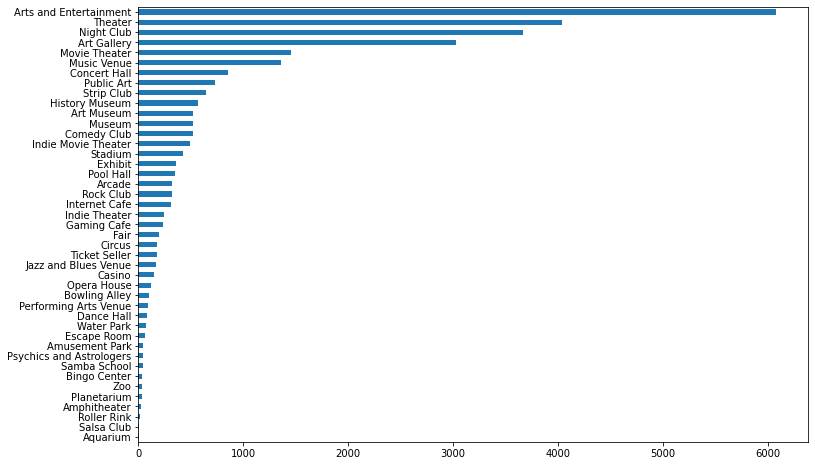

In [7]:
df_places['type_location'].value_counts(ascending=True).plot(kind='barh',figsize=(12,8))
plt.show()

##### Mounting dataframe to cluster

In [8]:
df_near_properties = mount_data_clustering(dataframe_places=df_places)

In [9]:
df_tmp = pd.concat([data_quintoAndar,df_near_properties],axis=1)

##### Processing data

In [10]:
X = df_tmp.drop(
    ['id', 'lat', 'lon',
    'street','neighborhood','city'],axis=1)
X = pd.get_dummies(X)
X.fillna(0,inplace=True)

##### Rescaler data

In [11]:
scaler = StandardScaler()
data_rescaled = scaler.fit(X)
data_rescaled = scaler.transform(X)

##### Decompose data into less dimensions

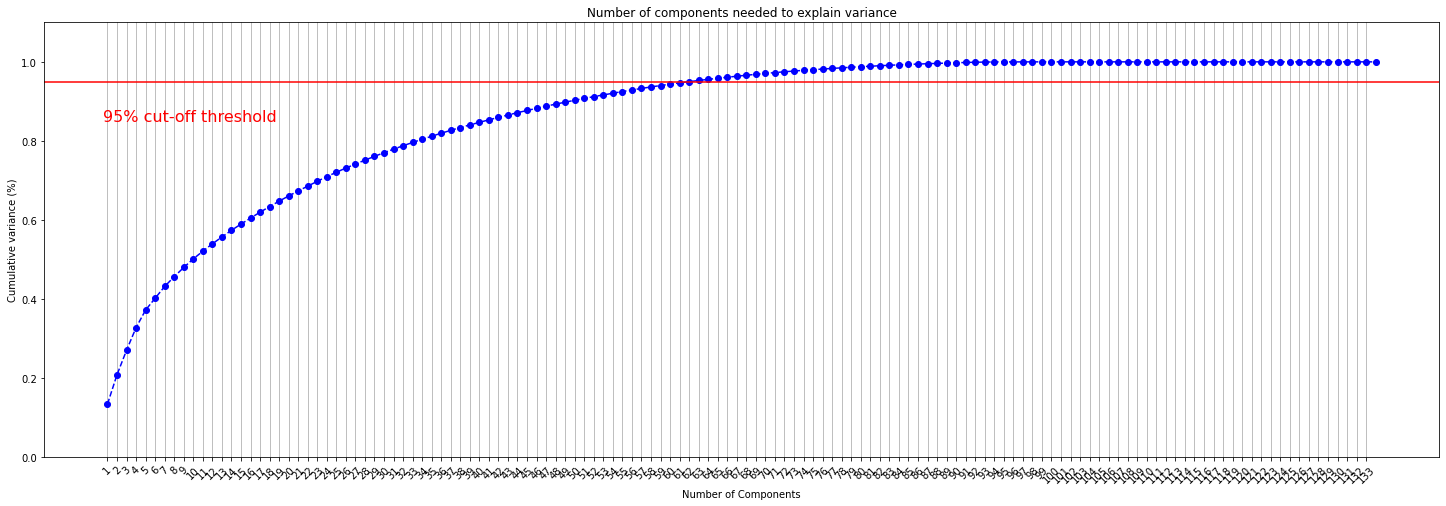

In [38]:
# Verifying number of components are ideal to represent all data.
pca = PCA().fit(data_rescaled)
plt.rcParams["figure.figsize"] = (25,8)

fig, ax = plt.subplots()
xi = np.arange(1,135, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 134, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title("Number of components needed to explain variance")

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
plt.xticks(rotation=45)

ax.grid(axis='x')
plt.show()

In [39]:
# Create model to reduce dimension data
reduce_dimension = PCA(n_components=62)
reduce_dimension.fit(data_rescaled)
reduced_data = reduce_dimension.transform(data_rescaled)

In [40]:
# Create model to clustering data
len(reduced_data[0])

62